In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud
from nltk.corpus import stopwords

<h3>Questions</h3>
<p>- How the the views, likes, dislikes, and other statistics plotted overtime?</p>
<p>- What are the tags that trend on Indonesia?</p>
<p>- How long it usually took the video to blow up on trending page?</p>
<p>- What are the categories that people interested in?</p>

In [2]:
yt_ina_clean = pd.read_csv('datasets/INA_youtube_trending_data.csv', low_memory=False)
yt_ina_clean.head(2)

,video_id,publish_time,channel_id,title,description,thumbnail_url,thumbnail_width,thumbnail_height,channel_name,tags,...,caption,license_status,allowed_region,blocked_region,view,like,dislike,favorite,comment,trending_time
0,NaN,2021-02-05T09:00:34Z,UCEf_Bc-KVd7onSeifS3py9g,aespa 에스파 'Forever (약속)' MV,"aespa's new single ""Forever"" is out!\nListen a...",NaN,NaN,NaN,SMTOWN,NaN,...,True,True,NaN,NaN,7806846.0,857902.0,24078.0,0,94961.0,2021-02-07 05:46:51.832614+00:00
1,NaN,2021-02-04T15:54:08Z,UCYEa4_MC7OFjcWrO6SO-u8g,[FULL] Siapa di Balik Kudeta AHY? | Dua Sisi t...,"Jakarta, https://www.tvonenews.com - Ketua umu...",NaN,NaN,NaN,Indonesia Lawyers Club,"['tvone', 'tv one', 'tvonenews', 'indonesia la...",...,False,True,NaN,NaN,885038.0,6765.0,1263.0,0,6365.0,2021-02-07 05:46:51.832649+00:00


In [3]:
yt_ina_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128150 entries, 0 to 128149
Data columns (total 27 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   video_id           75028 non-null   object 
 1   publish_time       128150 non-null  object 
 2   channel_id         128150 non-null  object 
 3   title              128150 non-null  object 
 4   description        123422 non-null  object 
 5   thumbnail_url      75028 non-null   object 
 6   thumbnail_width    75028 non-null   float64
 7   thumbnail_height   75028 non-null   float64
 8   channel_name       128150 non-null  object 
 9   tags               110710 non-null  object 
 10  category_id        128150 non-null  int64  
 11  live_status        128150 non-null  object 
 12  local_title        128150 non-null  object 
 13  local_description  123422 non-null  object 
 14  duration           128150 non-null  object 
 15  dimension          128150 non-null  object 
 16  de

<h2>Preprocess The Data</h2>
<p>- Drop unrelated columns</p>
<p>- Handling null values</p>
<p>- Change dtype</p>

In [231]:
#Drop unrelated columns
yt_ina_clean = yt_ina_clean[['publish_time', 'title', 'channel_name', 'view', 'like', 'dislike', 'comment', 'trending_time', 'tags', 'category_id', 'live_status', 'duration', 'allowed_region', 'blocked_region']]

#Handling null values
yt_ina_clean.view.fillna(yt_ina_clean.view.mean(), inplace=True)
yt_ina_clean.dislike.fillna(yt_ina_clean.dislike.mean(), inplace=True)
yt_ina_clean.like.fillna(yt_ina_clean.like.mean(), inplace=True) 
yt_ina_clean.comment.fillna(yt_ina_clean.comment.mean(), inplace=True)
yt_ina_clean.tags.fillna('NoTags', inplace=True)

#change datatypes
yt_ina_clean.publish_time = pd.to_datetime(yt_ina_clean.publish_time, format='%Y-%m-%d %H:%M:%S')
yt_ina_clean.trending_time = pd.to_datetime(yt_ina_clean.trending_time, format='%Y-%m-%d %H:%M:%S')

def duration_clean(str_time):
    x = re.split(r'\D+', str_time)
    x = list(filter(None, x))

    if len(x) < 2 : x = dt.datetime.strptime('|'.join(x[::-1]), '%S')
    elif len(x) < 3 : x = dt.datetime.strptime('|'.join(x[::-1]), '%S|%M')
    elif len(x) < 4 : x = dt.datetime.strptime('|'.join(x[::-1]), '%S|%M|%H')
    else : x = dt.datetime.strptime('|'.join(x[::-1]), '%S|%M|%H|%d')
   
    return x
    
yt_ina_clean.duration = yt_ina_clean.duration.apply(func=duration_clean)

def tags_clean(tags):
    tags = tags[1:-1].split("', '")
    for tag in tags:
        tag = re.sub(r'\W+', '', tag)
    return ", ".join(tags)

yt_ina_clean.tags = yt_ina_clean.tags.apply(func=tags_clean)

category = pd.read_json('datasets/INA_category_id.json')
category = category['items']

#make a new dataframe that correspond to category on json files
genre_id= []
genre = []

for i in range(0, len(category)-1):
    genre_id.append(str(category[i]).split(", ")[2].split(': ')[-1].strip("'"))
    genre.append(str(category[i]).split(", ")[3].split(': ')[-1].strip("'"))

genre = pd.DataFrame(list(zip(genre_id, genre)), columns=['id', 'genre']).set_index('id')
yt_ina_clean['category'] = yt_ina_clean['category_id'].apply(lambda x : genre.loc[str(x)]['genre'] if x != 29 else "Nonprofits & Activism")

yt_ina_clean.drop('category_id', axis=1)

#Drop unrelated columns
yt_ina_clean = yt_ina_clean[['publish_time', 'trending_time', 'title', 'channel_name', 'category', 'view', 'like', 'dislike', 'comment', 'tags' ,'live_status', 'duration', 'allowed_region', 'blocked_region']]

C:\Users\HP G7\AppData\Local\Temp\ipykernel_14300\2159503413.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yt_ina_clean.view.fillna(yt_ina_clean.view.mean(), inplace=True)
C:\Users\HP G7\AppData\Local\Temp\ipykernel_14300\2159503413.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yt_ina_clean.dislike.fillna(yt_ina_clean.dislike.mean(), inplace=True)
C:\Users\HP G7\AppData\Local\Temp\ipykernel_14300\2159503413.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

<h3>Analyze </h3>

- Plot published time and trend time
- Popular tags
- Popular channel
- View, like, dislike, comment, ratio
- Popular category

In [232]:
yt_ina_clean.head(2)

,publish_time,trending_time,title,channel_name,category,view,like,dislike,comment,tags,live_status,duration,allowed_region,blocked_region
0,2021-02-05 09:00:34+00:00,2021-02-07 05:46:51.832614+00:00,aespa 에스파 'Forever (약속)' MV,SMTOWN,Music,7806846.0,857902.0,24078.0,94961.0,oTag,none,1900-01-01 00:05:07,NaN,NaN
1,2021-02-04 15:54:08+00:00,2021-02-07 05:46:51.832649+00:00,[FULL] Siapa di Balik Kudeta AHY? | Dua Sisi t...,Indonesia Lawyers Club,News & Politics,885038.0,6765.0,1263.0,6365.0,"'tvone, tv one, tvonenews, indonesia lawyers c...",none,1900-01-01 00:42:30,NaN,NaN


<Figure size 800x1280 with 0 Axes>

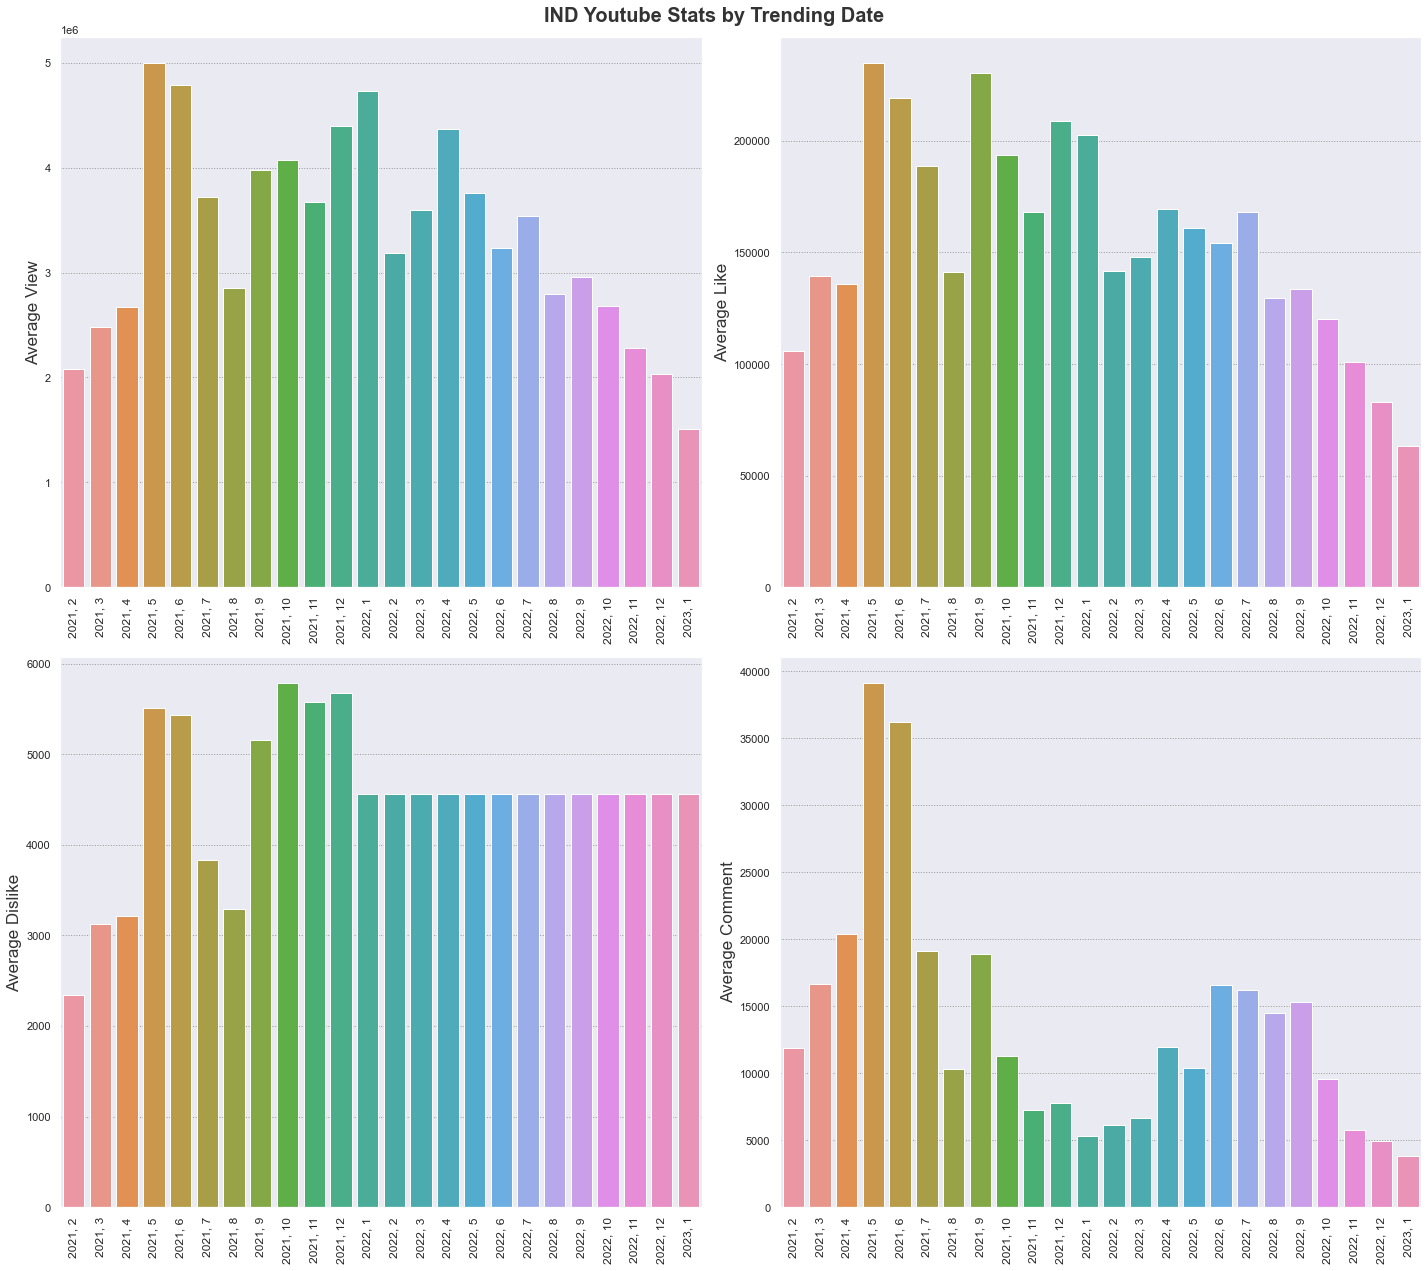

In [304]:
yt_ina_clean_monthstat = yt_ina_clean.groupby(yt_ina_clean.trending_time).mean().groupby(lambda x : (x.year, x.month)).mean()
date = []
for i in yt_ina_clean_monthstat.index:
    date.append(str(i).split(', ')[0].strip('(') + ", " + str(i).split(', ')[1].strip(')'))
yt_ina_clean_monthstat['date'] = date    

plt.figure(figsize=(10, 16), dpi=80)
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
fig, axes = plt.subplots(2, 2)

a = sns.barplot(data = yt_ina_clean_monthstat, x = 'date', y = 'view', ax=axes[0,0])
for tick in a.get_xticklabels():
    tick.set_rotation(90)
    tick.set_fontsize(12)
a.set_ylabel(ylabel = 'Average View', fontsize = 17, color='#333333')
a.set(xlabel=None)

b = sns.barplot(data = yt_ina_clean_monthstat, x = 'date', y = 'like', ax=axes[0,1])
for tick in b.get_xticklabels():
    tick.set_rotation(90)
    tick.set_fontsize(12)
b.set_ylabel(ylabel = 'Average Like', fontsize = 17, color='#333333')
b.set(xlabel=None)

c = sns.barplot(data = yt_ina_clean_monthstat, x = 'date', y = 'dislike', ax=axes[1,0])
for tick in c.get_xticklabels():
    tick.set_rotation(90)
    tick.set_fontsize(12)
c.set_ylabel(ylabel = 'Average Dislike', fontsize = 17, color='#333333')
c.set(xlabel=None)

d = sns.barplot(data = yt_ina_clean_monthstat, x = 'date', y = 'comment', ax=axes[1,1])
for tick in d.get_xticklabels():
    tick.set_rotation(90)
    tick.set_fontsize(12)
d.set_ylabel(ylabel = 'Average Comment', fontsize = 17, color='#333333')
d.set(xlabel=None)

fig.suptitle("IND Youtube Stats by Trending Date", fontsize=20, fontweight='bold', color='#333333')
plt.tight_layout()
plt.show()

<Figure size 800x1280 with 0 Axes>

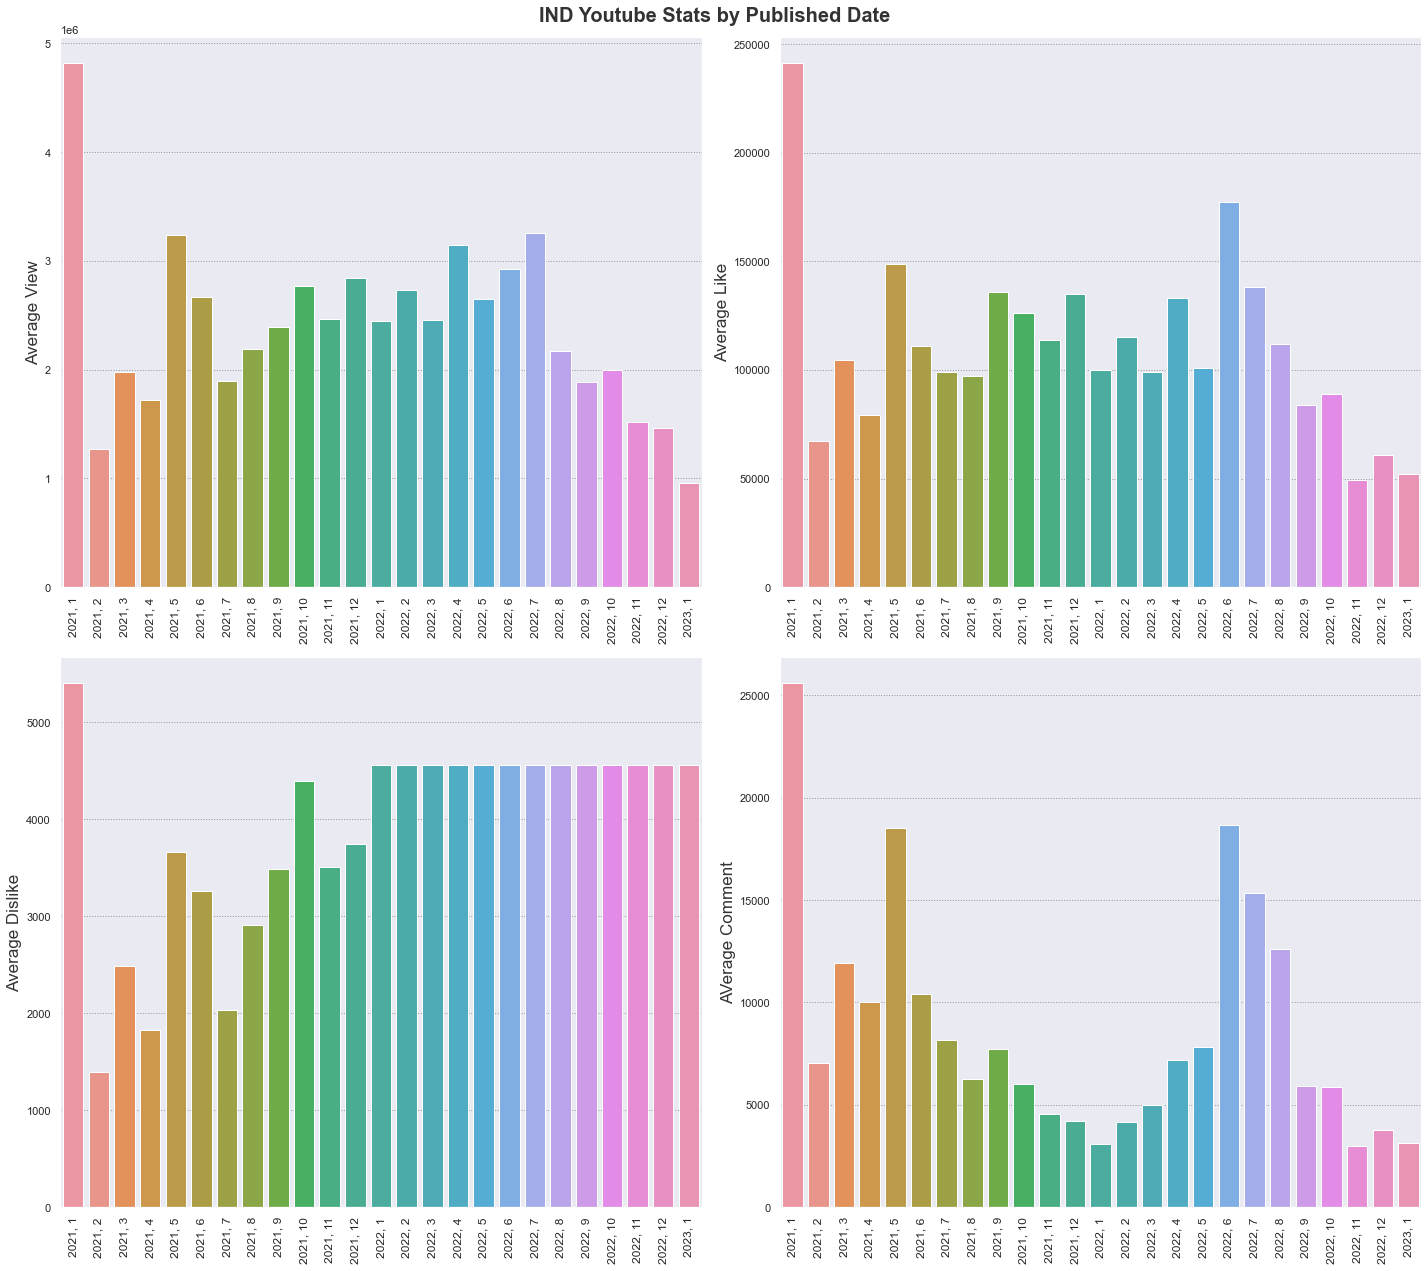

In [260]:
yt_ina_clean_monthstat = yt_ina_clean.groupby(yt_ina_clean.publish_time).mean().groupby(lambda x : (x.year, x.month)).mean()
date = []
for i in yt_ina_clean_monthstat.index:
    date.append(str(i).split(', ')[0].strip('(') + ", " + str(i).split(', ')[1].strip(')'))
yt_ina_clean_monthstat['date'] = date    

plt.figure(figsize=(10, 16), dpi=80)
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
fig, axes = plt.subplots(2, 2)

a = sns.barplot(data = yt_ina_clean_monthstat, x = 'date', y = 'view', ax=axes[0,0])
for tick in a.get_xticklabels():
    tick.set_rotation(90)
    tick.set_fontsize(12)
a.set_ylabel(ylabel = 'Average View', fontsize = 17, color='#333333')
a.set(xlabel=None)

b = sns.barplot(data = yt_ina_clean_monthstat, x = 'date', y = 'like', ax=axes[0,1])
for tick in b.get_xticklabels():
    tick.set_rotation(90)
    tick.set_fontsize(12)
b.set_ylabel(ylabel = 'Average Like', fontsize = 17, color='#333333')
b.set(xlabel=None)

c = sns.barplot(data = yt_ina_clean_monthstat, x = 'date', y = 'dislike', ax=axes[1,0])
for tick in c.get_xticklabels():
    tick.set_rotation(90)
    tick.set_fontsize(12)
c.set_ylabel(ylabel = 'Average Dislike', fontsize = 17, color='#333333')
c.set(xlabel=None)

d = sns.barplot(data = yt_ina_clean_monthstat, x = 'date', y = 'comment', ax=axes[1,1])
for tick in d.get_xticklabels():
    tick.set_rotation(90)
    tick.set_fontsize(12)
d.set_ylabel(ylabel = 'AVerage Comment', fontsize = 17, color='#333333')
d.set(xlabel=None)

fig.suptitle("IND Youtube Stats by Published Date", fontsize=20, fontweight='bold', color='#333333')
plt.tight_layout()
plt.show()

In [291]:
yt_ina_2021 = yt_ina_clean[yt_ina_clean.trending_time.dt.year == 2021]
yt_ina_2022 = yt_ina_clean[yt_ina_clean.trending_time.dt.year == 2022]

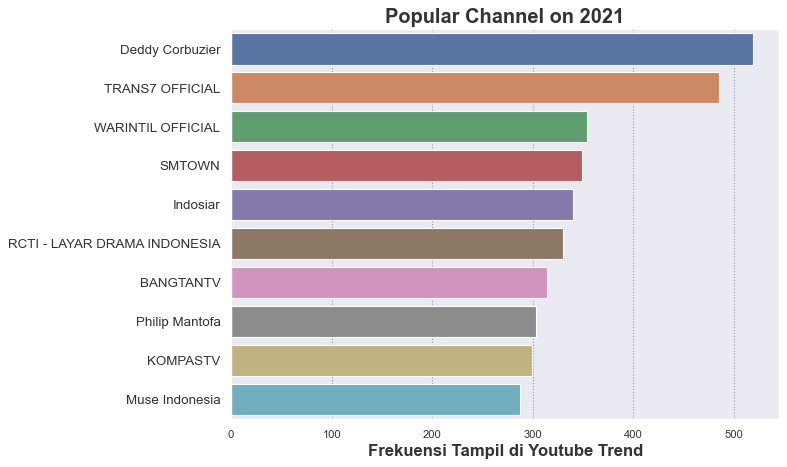

In [283]:
yt_ina_channel_2021 = pd.DataFrame(yt_ina_clean[yt_ina_clean.trending_time.dt.year == 2021]['channel_name'].value_counts().head(10))

plt.figure(figsize=(10, 6), dpi=80)
a = sns.barplot(data=yt_ina_channel_2021, y=yt_ina_channel_2021.index, x='channel_name')
a.set_xlabel('Frekuensi Tampil di Youtube Trend', fontsize=15, fontweight='bold', color='#333333')
for tick in a.get_xticklabels():
    tick.set_fontsize(10)
    tick.set_color('#333333')
for tick in a.get_yticklabels():
    tick.set_fontsize(12)
    tick.set_color('#333333')
plt.title('Popular Channel on 2021', fontsize=18, fontweight='bold', color='#333333')
plt.tight_layout()
plt.show()

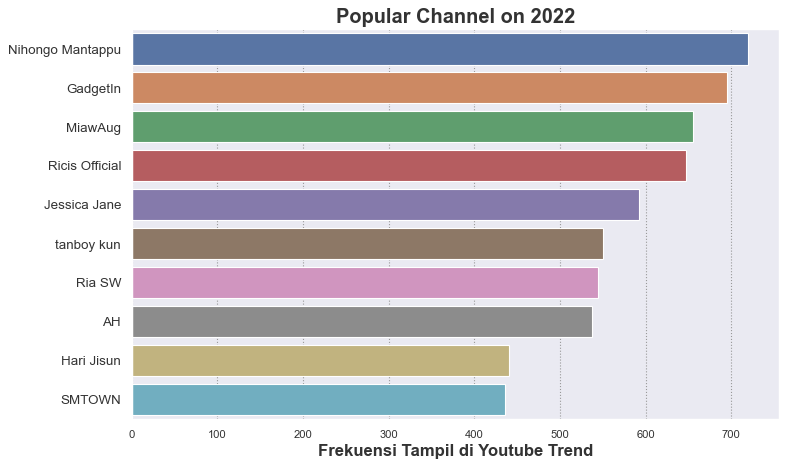

In [285]:
yt_ina_channel_2022 = pd.DataFrame(yt_ina_clean[yt_ina_clean.trending_time.dt.year == 2022]['channel_name'].value_counts().head(10))

plt.figure(figsize=(10, 6), dpi=80)
a = sns.barplot(data=yt_ina_channel_2022, y=yt_ina_channel_2022.index, x='channel_name')
a.set_xlabel('Frekuensi Tampil di Youtube Trend', fontsize=15, fontweight='bold', color='#333333')
for tick in a.get_xticklabels():
    tick.set_fontsize(10)
    tick.set_color('#333333')
for tick in a.get_yticklabels():
    tick.set_fontsize(12)
    tick.set_color('#333333')
plt.title('Popular Channel on 2022', fontsize=18, fontweight='bold', color='#333333')
plt.tight_layout()
plt.show()

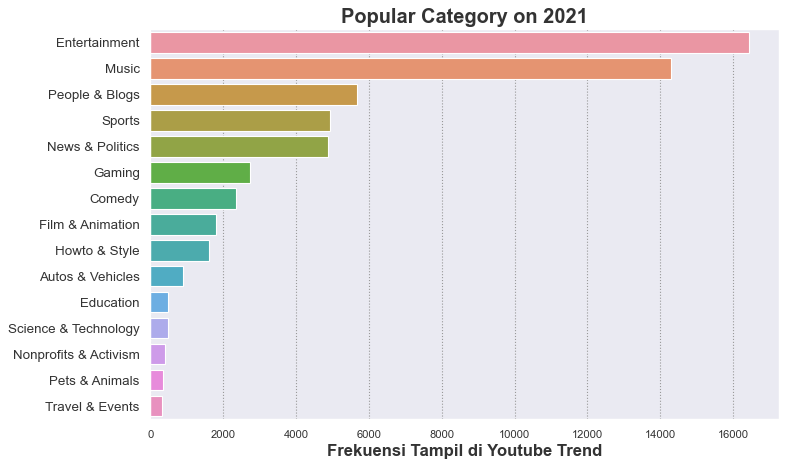

In [288]:
yt_ina_category_2021 = pd.DataFrame(yt_ina_clean[yt_ina_clean.trending_time.dt.year == 2021]['category'].value_counts())

plt.figure(figsize=(10, 6), dpi=80)
a = sns.barplot(data=yt_ina_category_2021, y=yt_ina_category_2021.index, x='category')
a.set_xlabel('Frekuensi Tampil di Youtube Trend', fontsize=15, fontweight='bold', color='#333333')
for tick in a.get_xticklabels():
    tick.set_fontsize(10)
    tick.set_color('#333333')
for tick in a.get_yticklabels():
    tick.set_fontsize(12)
    tick.set_color('#333333')
plt.title('Popular Category on 2021', fontsize=18, fontweight='bold', color='#333333')
plt.tight_layout()
plt.show()

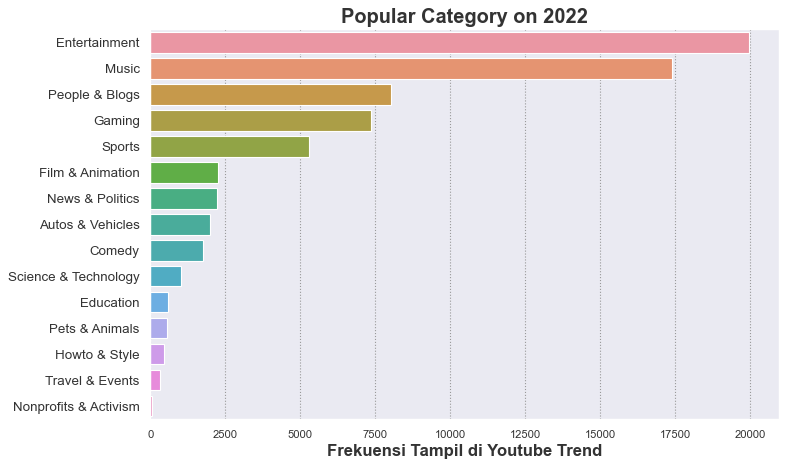

In [287]:
yt_ina_category_2022 = pd.DataFrame(yt_ina_clean[yt_ina_clean.trending_time.dt.year == 2022]['category'].value_counts())

plt.figure(figsize=(10, 6), dpi=80)
a = sns.barplot(data=yt_ina_category_2022, y=yt_ina_category_2022.index, x='category')
a.set_xlabel('Frekuensi Tampil di Youtube Trend', fontsize=15, fontweight='bold', color='#333333')
for tick in a.get_xticklabels():
    tick.set_fontsize(10)
    tick.set_color('#333333')
for tick in a.get_yticklabels():
    tick.set_fontsize(12)
    tick.set_color('#333333')
plt.title('Popular Category on 2022', fontsize=18, fontweight='bold', color='#333333')
plt.tight_layout()
plt.show()

C:\Users\HP G7\AppData\Local\Temp\ipykernel_14300\2276584129.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yt_ina_2021['ratio'] = yt_ina_2021['like']/yt_ina_2021['dislike']
C:\Users\HP G7\AppData\Local\Temp\ipykernel_14300\2276584129.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yt_ina_2021['feedback'] = yt_ina_2021['ratio'].apply(lambda x : 'Positif' if x >= 1.0 else 'Negatif')


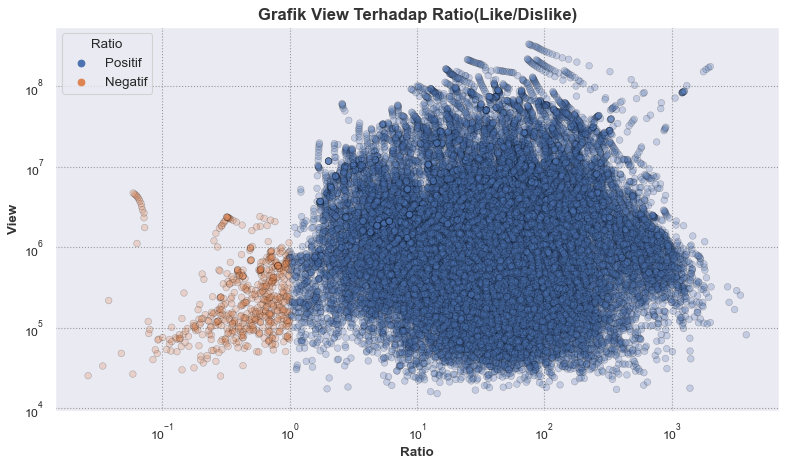

In [364]:
plt.figure(figsize=(10, 6), dpi=80)
yt_ina_2021['ratio'] = yt_ina_2021['like']/yt_ina_2021['dislike']
yt_ina_2021['feedback'] = yt_ina_2021['ratio'].apply(lambda x : 'Positif' if x >= 1.0 else 'Negatif')
a = sns.scatterplot(data=yt_ina_2021, x='ratio', y='view', edgecolor='black', alpha=.25, hue='feedback')
a.set(xscale='log', yscale='log')
a.set_xlabel('Ratio', fontsize=12., fontweight='bold', color='#333333')
a.set_ylabel('View', fontsize=12, fontweight='bold', color='#333333')

plt.title('Grafik View Terhadap Ratio(Like/Dislike) 2021', fontsize=15, fontweight='bold', color='#333333')
plt.legend(title='Ratio', fontsize=12)
plt.tight_layout()
plt.show()

C:\Users\HP G7\AppData\Local\Temp\ipykernel_14300\1439782988.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yt_ina_2022['ratio'] = yt_ina_2022['like']/yt_ina_2022['dislike']
C:\Users\HP G7\AppData\Local\Temp\ipykernel_14300\1439782988.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yt_ina_2022['feedback'] = yt_ina_2022['ratio'].apply(lambda x : 'Positif' if x >= 1.0 else 'Negatif')


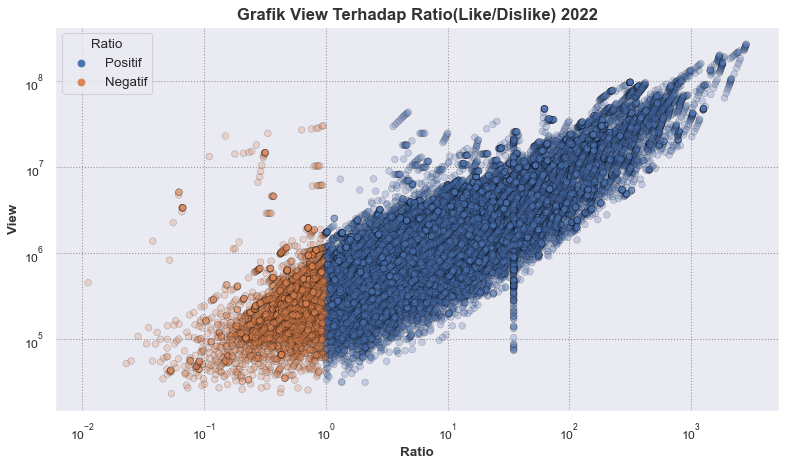

In [365]:
# plt.figure(figsize=(10, 6), dpi=80)
# yt_ina_2022['ratio'] = yt_ina_2022['like']/yt_ina_2022['dislike']
# yt_ina_2022['feedback'] = yt_ina_2022['ratio'].apply(lambda x : 'Positif' if x >= 1.0 else 'Negatif')
# a = sns.scatterplot(data=yt_ina_2022, x='ratio', y='view', edgecolor='black', alpha=.25, hue='feedback')
# a.set(xscale='log', yscale='log')
# a.set_xlabel('Ratio', fontsize=12., fontweight='bold', color='#333333')
# a.set_ylabel('View', fontsize=12, fontweight='bold', color='#333333')

# plt.title('Grafik View Terhadap Ratio(Like/Dislike) 2022', fontsize=15, fontweight='bold', color='#333333')
# plt.legend(title='Ratio', fontsize=12)
# plt.tight_layout()
# plt.show()

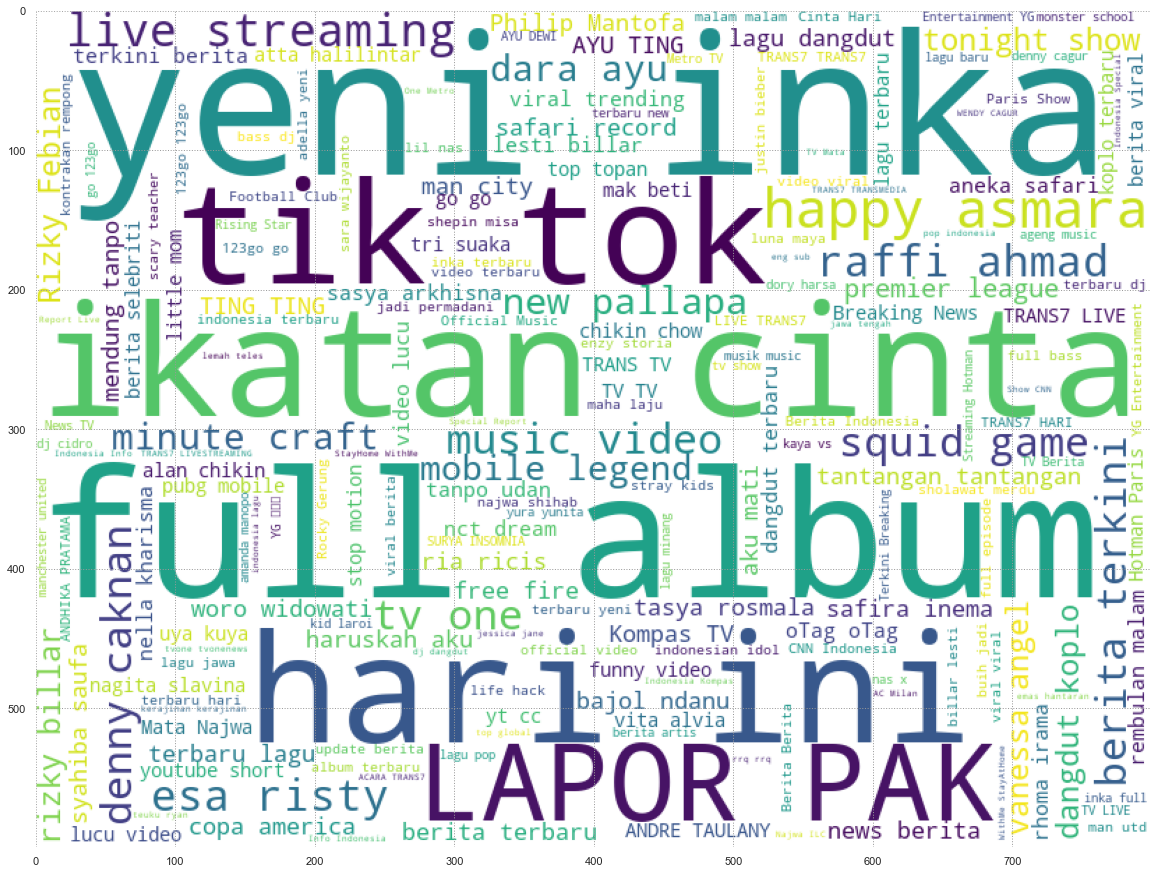

In [366]:
yt_ina_2021_tags = []

for i in yt_ina_2021['tags']:
    for j in str(i).split(', '):
        yt_ina_2021_tags.append(j)
tags_2021 = ' '.join(yt_ina_2021_tags)

wc2021 = WordCloud(background_color='white', width=800, height=600).generate(tags_2021)
plt.imshow(wc2021)

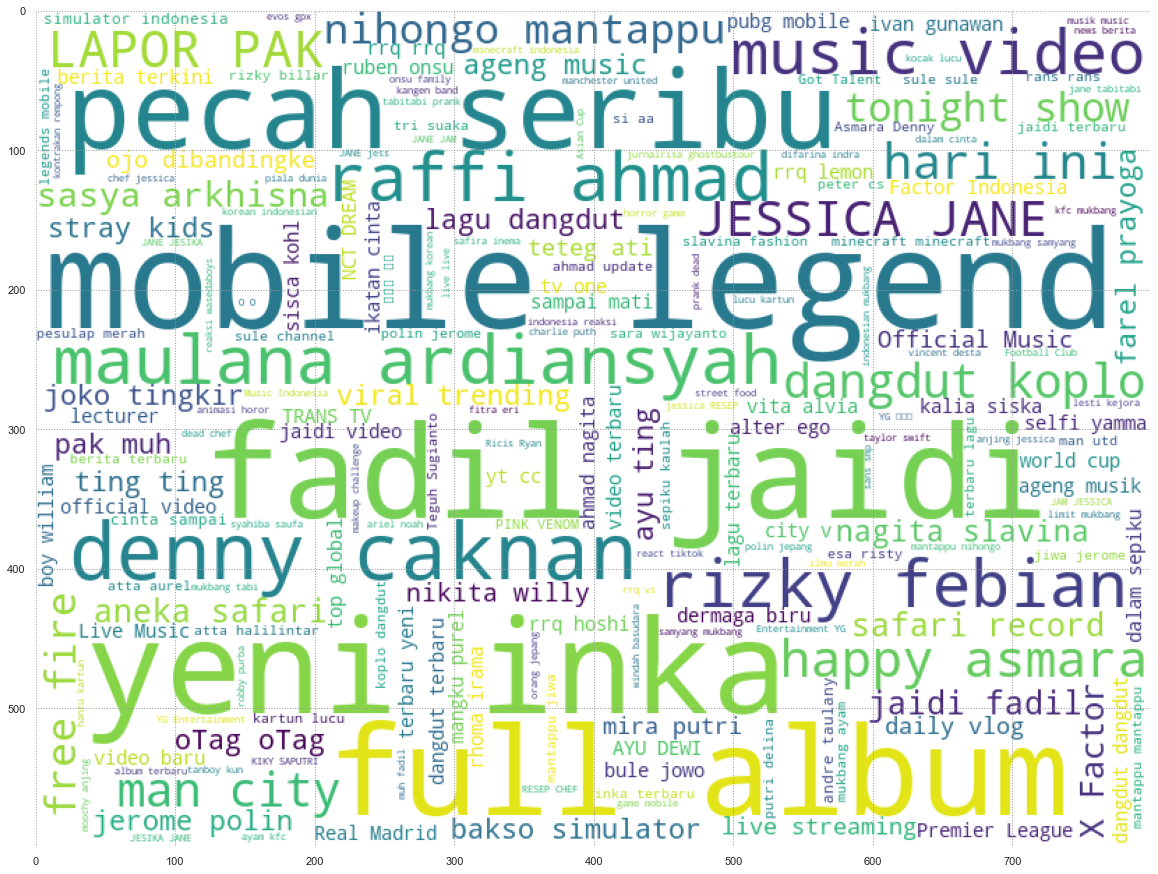

In [367]:
yt_ina_2022_tags = []

for i in yt_ina_2022['tags']:
    for j in str(i).split(', '):
        yt_ina_2022_tags.append(j)
tags_2022 = ' '.join(yt_ina_2022_tags)

wc2022 = WordCloud(background_color='white', width=800, height=600).generate(tags_2022)
plt.imshow(wc2022)

In [380]:
pd.DataFrame((yt_ina_clean['trending_time'] - yt_ina_clean['publish_time']).dt.days).describe()

,0
count,128150.000000
mean,7.998767
std,7.612460
min,0.000000
25%,2.000000
50%,6.000000
75%,11.000000
max,36.000000


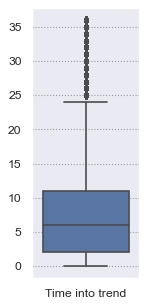

In [391]:
plt.figure(figsize=(2,4), dpi=80)
yt_ina_timeintotrend = pd.DataFrame((yt_ina_clean['trending_time'] - yt_ina_clean['publish_time']).dt.days)
yt_ina_timeintotrend.columns = ['Time into trend']
sns.boxplot(data = yt_ina_timeintotrend)
plt.tight_layout()
plt.show()

In [392]:
yt_ina_clean.head(1)

,publish_time,trending_time,title,channel_name,category,view,like,dislike,comment,tags,live_status,duration,allowed_region,blocked_region,day_to_trend
0,2021-02-05 09:00:34+00:00,2021-02-07 05:46:51.832614+00:00,aespa 에스파 'Forever (약속)' MV,SMTOWN,Music,7806846.0,857902.0,24078.0,94961.0,oTag,none,1900-01-01 00:05:07,NaN,NaN,1
